In [25]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.linalg import solve, inv, cholesky
from scipy.stats import norm

#### Set up training data and function

(50, 1)


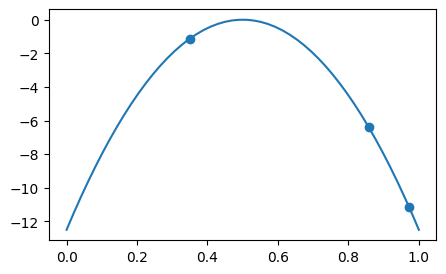

In [21]:
np.random.seed(10004000) # fixed for reproducibility
train_x = np.random.uniform(0,1,3).reshape(-1, 1)
f = lambda x: -0.5*100*(x-0.5)**2 

train_y = f(train_x)

# points at which we will test the GP prediction
test_x =  np.linspace(0,1,50).reshape(-1, 1)
test_y = f(test_x)
print(np.shape(test_x))

plt.figure(figsize=(5,3))
plt.scatter(train_x,train_y)
plt.plot(test_x,test_y)

#### Create our GP, following algorithm 2.1 of Rasmussen and Williams (2006)

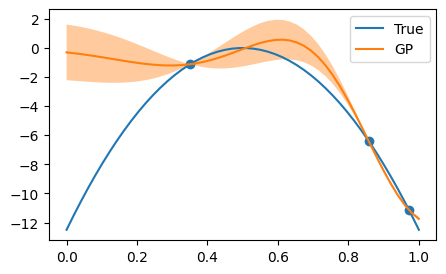

In [24]:
# covariance function, we will use the squared exponential also called the radial basis function (RBF) kernel

def rbf_kernel(xa,xb,lengthscales=0.2,outputscale=1.):
    dist = cdist(xa/lengthscales,xb/lengthscales,metric="sqeuclidean")
    dist = np.exp(-0.5*dist)
    return outputscale*dist

# simple method to get the GP predictions, mean and variance at our test points
def gp_predict(test_x,train_x=train_x,train_y=train_y,noise=1e-6):
    # adding noise to the covariance at the trainig points helps with numerical stability, can also be interpreted as 'noisy' observations
    k11 = rbf_kernel(train_x,train_x)+noise*np.eye(train_x.shape[0]) 
    k12 = rbf_kernel(train_x,test_x)
    k22 = rbf_kernel(test_x,test_x)
    sol = solve(k11,k12,assume_a='pos').T # the transpose gives k21*k11_inv
    mu = sol @ train_y
    var = k22 - sol @ k12
    return mu[:,0], np.diag(var)

mu, var = gp_predict(test_x)
std = np.sqrt(var)

# plot our GP predictions
plt.figure(figsize=(5,3))
plt.plot(test_x,test_y,label='True')
plt.plot(test_x,mu,label='GP')
plt.scatter(train_x,train_y)
plt.fill_between(test_x[:,0],mu-1.96*std,mu+1.96*std,alpha=0.4)
plt.legend();

#### Now, you need to find the optimal hyperparameters, i.e. the ones that maximize the marginal log-likelihood of the GP. 
$\log P = -\frac{1}{2}y^T (K+\sigma^2_n I)^{-1} y-\frac{1}{2}\log|K+\sigma^2_n I| -\frac{n}{2}\log(2\pi)$, 
$y$ are the function values at the training points, $K$ is covariance at the training points, $n$ is number of training points

#### Let's move on to a more complicated function, pick one of the 2D functions used for the HMC example and try to fit a Gaussian process to it.

We know that given a set of training points, we can find the optimal set of hyperparameters. But how would you chose the best set of training points that allow you to model the true function with as few training points as possible. This really depends on what the true function represents, let us say in our example it is a likelihood and we wish to find its maximum in as few function evaluations as possible. This is essentially what Bayesian Optimization is and the choice of strategy to acquire new points is called an acquisition function. We will use here the Expected Improvement acquisition function, which represents the expectation value of the improvement over the current observed largest function value. This is well suited for finding the peak of the likelihood.

In [26]:
# skeleton code which you need to fill up
def EI(x,best_obs):
    mu, var = gp_predict(x,...) 
    z = (mu - best_obs)/np.sqrt(var)
    return (mu - best_obs) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)


#### The Bayesian Optimization algorithm can be summed up as follows

1. Start with a small set of random points, or even better a set of points that uniformly covers the parameter space. Fit the GP to these points (find optimal hyperparameters)
2. Find maximum of acquisition function, say $x_*$. Evaluate $y_* = f(x_*)$ and add $(x_*,y_*)$ to the training data. Refit the GP.
3. Repeat step 2 until value of acquisition function at maximum becomes quite small, say $0.01$. 

In [27]:
#while (acq_value>0.01):
    # find max of EI
    # add to training data and fit GP

Now compare your GP prediction and true function values. How well did the GP do at finding the global maxima and the function value at that point? What about learning the global shape of the function? An interesting thing to do would be to run your MCMC/HMC on the true function as well as the GP (using the GP mean prediction) and see how the results compare.